아래의 git을 다운 받으면 'learnopencv/OpenPose-Multi-Person'에 해당 코드 파일이 첨부되어 있습니다.

# git 다운 받기

In [ ]:
!git clone https://github.com/spmallick/learnopencv.git

In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from random import randint

In [2]:
# 아래 해당 두 파일을 직접 다운 받아 pose/coco 폴더에 각각 넣어줌
protoFile = "pose/coco/pose_deploy_linevec.prototxt.txt"
weightsFile = "pose/coco/pose_iter_440000.caffemodel"

nPoints = 18

# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs(part affinity fields => 운동 방향) correspoding to the POSE_PAIRS
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [[0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

In [5]:
image1 = cv2.imread("three.jpg")
print(image1.shape)          # (세로 길이, 가로 길이, RGB)

frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

(600, 400, 3)


In [6]:
t = time.time()

# Read the network into memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
H = output.shape[2]
W = output.shape[3]
print(output.shape)

print("Time Taken = {}".format(time.time() - t))

(1, 57, 46, 31)
Time Taken = 3.24249267578125


(-0.5, 399.5, 599.5, -0.5)

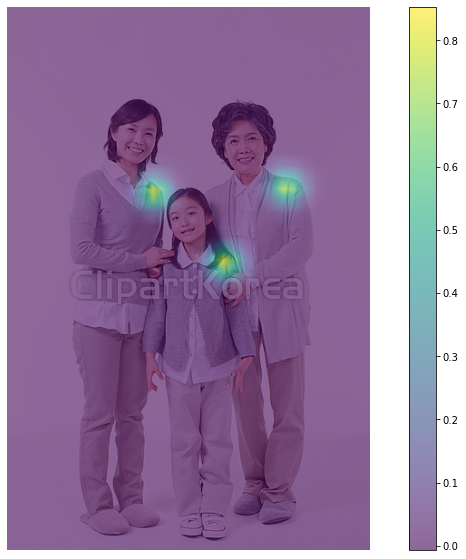

In [7]:
i = 5
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))

plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [8]:
probMap

array([[0.00034678, 0.00034678, 0.00034678, ..., 0.0002725 , 0.0002725 ,
        0.0002725 ],
       [0.00034678, 0.00034678, 0.00034678, ..., 0.0002725 , 0.0002725 ,
        0.0002725 ],
       [0.00034678, 0.00034678, 0.00034678, ..., 0.0002725 , 0.0002725 ,
        0.0002725 ],
       ...,
       [0.00055611, 0.00055611, 0.00055611, ..., 0.00028013, 0.00028013,
        0.00028013],
       [0.00055611, 0.00055611, 0.00055611, ..., 0.00028013, 0.00028013,
        0.00028013],
       [0.00055611, 0.00055611, 0.00055611, ..., 0.00028013, 0.00028013,
        0.00028013]], dtype=float32)

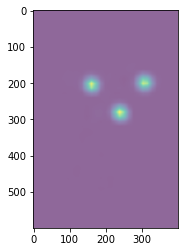

In [9]:
probMap.shape
plt.imshow(probMap, alpha=0.6)

In [10]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)
    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    # find the blobs
#     _,contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

In [11]:
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))


    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)

Keypoints - Nose : [(188, 240, 0.8121269), (252, 150, 0.7765698), (147, 149, 0.8447039)]
Keypoints - Neck : [(200, 280, 0.8398065), (264, 202, 0.84878325), (123, 201, 0.80832183)]
Keypoints - R-Sho : [(173, 281, 0.7472563), (225, 213, 0.6711854), (95, 189, 0.7284812)]
Keypoints - R-Elb : [(160, 333, 0.66993374), (83, 267, 0.8332451)]
Keypoints - R-Wr : [(161, 384, 0.7937142), (147, 280, 0.8710914)]
Keypoints - L-Sho : [(238, 280, 0.8527937), (161, 202, 0.8103194), (304, 201, 0.7282359)]
Keypoints - L-Elb : [(252, 345, 0.62044126), (162, 268, 0.17622827), (327, 266, 0.6460946)]
Keypoints - L-Wr : [(263, 384, 0.46388805), (276, 293, 0.5574311)]
Keypoints - R-Hip : [(187, 398, 0.70425236), (96, 333, 0.6293025), (251, 333, 0.4435609)]
Keypoints - R-Knee : [(198, 475, 0.65928185), (97, 449, 0.725475), (264, 436, 0.49364406)]
Keypoints - R-Ank : [(187, 553, 0.65340096), (96, 553, 0.76621205), (264, 527, 0.6607646)]
Keypoints - L-Hip : [(227, 397, 0.6054539), (147, 333, 0.59676796), (303, 332

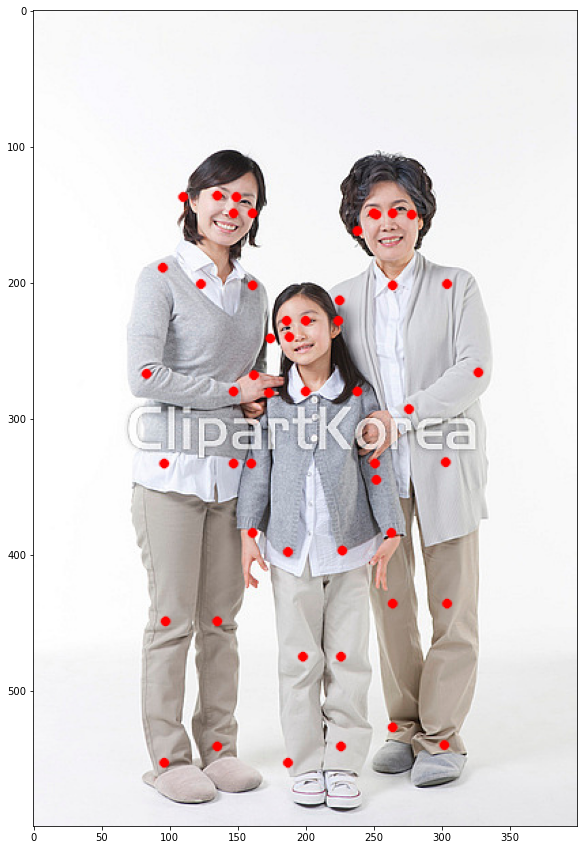

In [12]:
frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [13]:
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # 모든 POSE_PAIR에 대해
    for k in range(len(mapIdx)):
        # limb의 한쪽 조인트 A, 다른쪽 조인트B 각각에 대한 paf
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # limb의 양쪽 keypoint 후보들
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)
        
        # joint keypoint가 detect된 경우에 한해
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            # 조인트들 사이의 모든 interpolated points 집합에 대해 PAF를 계산한다
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):         
                    # 두 joint 사이의 distance vector(d_ij)계산
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    # distance vector(d_ij)를 normalize
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)

                    # Connection이 valid한지 체크하기 위해 threshold로 걸러낸다  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Valid한 connection들 저장
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # valid_pair과 valid_pairs 다름 주의 - valid_pairs는 global variable
            valid_pairs.append(valid_pair)
            
        # Keypoint가 detect되지 않았을 경우
        else: 
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs          

In [14]:
valid_pairs, invalid_pairs = getValidPairs(output)

[array([[3.        , 6.        , 0.74890031],
       [4.        , 7.        , 0.78819857],
       [5.        , 8.        , 0.82581299]]), array([[ 3.        , 13.        ,  0.87407231],
       [ 4.        , 15.        ,  0.92306396],
       [ 5.        , 14.        ,  0.93907452]]), array([[ 6.        ,  9.        ,  0.80740254],
       [ 8.        , 10.        ,  0.86071321]]), array([[ 9.        , 11.        ,  0.85753536],
       [10.        , 12.        ,  0.80330551]]), array([[13.        , 16.        ,  0.75141391],
       [14.        , 17.        ,  0.47093419],
       [15.        , 18.        ,  0.77387642]]), array([[16.        , 19.        ,  0.65365462],
       [18.        , 20.        ,  0.71524253]]), array([[ 3.        , 21.        ,  0.74105044],
       [ 4.        , 23.        ,  0.69475966],
       [ 5.        , 22.        ,  0.74717302]]), array([[21.        , 24.        ,  0.84914517],
       [22.        , 25.        ,  0.85723387],
       [23.        , 26.        , 

In [15]:
# for each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs): 
    #각 사람의 keypoints를 저장하기 위한 empty list 생성
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])
            #valid_pair 각각에 대해, partA가 personwiseKeypoints에 있는지 확인
            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break
                # 만약 partA가 있다면, partB도 personwiseKeypoints에 추가
                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # 만댝 partA가 모든 list에 없다면, list에 없는 새로운 사람의 part라는 뜻
                elif not found and k < 17:
                    # partA-partB 전체를 한 row로 생성해서 추가
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # 각 keypoint의 keypoint_scores와 paf_score도 추가
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [16]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

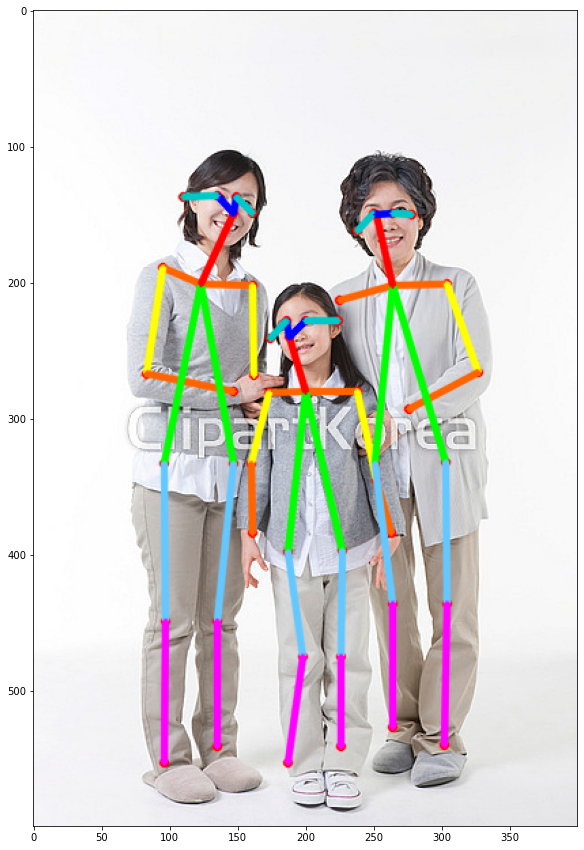

In [17]:
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])